# Project: Image Caption Generator (VGG16 + LSTM)
**Course:** Deep Learning & Classification Techniques
**Students:** Mazen Mohamed & Mohab Mohamed
**Date:** December 2025

---
**Project Overview:**
This project implements an end-to-end Deep Learning system to generate natural language descriptions for images. It utilizes a **Hybrid Architecture** combining:
* **Encoder:** VGG16 (CNN) for Visual Feature Extraction.
* **Decoder:** LSTM (RNN) for Sequence Generation.

The model is trained on the **Flickr8k dataset** and deployed using a custom inference loop to generate captions for real-world images.
---

# Phase 1: Setup & Feature Extraction
**Goal:** Initialize the environment and extract visual features from images.

**Steps:**
1.  **GPU Setup:** Configure TensorFlow to use the RTX 3050 GPU (with memory growth enabled).
2.  **Load Encoder:** Initialize **VGG16** (pre-trained on ImageNet).
3.  **Transfer Learning:** Remove the final classification layer to extract the 4,096-dimensional feature vector from the `fc2` layer.
4.  **Feature Extraction:** Loop through all images, resize to `(224, 224)`, and save the features to `features.pkl`.

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm  # Fixed: Changed from tqdm.notebook to avoid widget errors
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import tensorflow as tf

# We point to the specific environment folder we found earlier
path_to_cuda = r"C:\Users\mazen\anaconda3\envs\gpu_env\Library\bin"
try:
    os.add_dll_directory(path_to_cuda)
    print("✅ System Path updated for CUDA.")
except:
    pass

# Check GPU status
gpus = tf.config.list_physical_devices('GPU')
print(f"🎯 GPU Status: {len(gpus)} GPU(s) found. (If 0, we use CPU - it's fine!)")

# Where to save the output files (features.pkl)
WORKING_DIR = r"C:\Users\mazen\OneDrive\Desktop\university\Deep Learning and Classification Techniques\project"
if not os.path.exists(WORKING_DIR):
    os.makedirs(WORKING_DIR)

# Load VGG16 and remove the last classification layer
print("Loading VGG16 Model...")
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print("✅ Model Loaded.")

directory = r"C:\Users\mazen\OneDrive\Desktop\university\Deep Learning and Classification Techniques\project\archive\Images" 


print("Starting Feature Extraction... (This will take time)")
features = {}

all_images = os.listdir(directory)

for name in tqdm(all_images):
    filename = os.path.join(directory, name)
    image = load_img(filename, target_size=(224, 224))
    
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    feature = model.predict(image, verbose=0)
    
    image_id = name.split('.')[0]
    
    features[image_id] = feature

print("Saving features.pkl...")
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))
print("🎉 DONE! Features saved successfully.")

✅ System Path updated for CUDA.
🎯 GPU Status: 0 GPU(s) found. (If 0, we use CPU - it's fine!)
Loading VGG16 Model...
✅ Model Loaded.
Starting Feature Extraction... (This will take time)


100%|██████████| 8091/8091 [1:42:38<00:00,  1.31it/s]  


Saving features.pkl...
🎉 DONE! Features saved successfully.


# Phase 2: Text Preprocessing
**Goal:** Convert human-readable captions into machine-readable sequences.

**Steps:**
1.  **Load Data:** Read `captions.txt` (Flickr8k dataset).
2.  **Cleaning:** Lowercase all text, remove punctuation, and filter out single characters.
3.  **Tags:** Add `<startseq>` and `<endseq>` tokens so the LSTM understands sentence boundaries.
4.  **Tokenization:** Map every unique word to an integer index and save the `tokenizer.json` for later use.

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
import string

caption_path = r"C:\Users\mazen\OneDrive\Desktop\university\Deep Learning and Classification Techniques\project\archive\captions.txt"

print("Loading captions...")
with open(caption_path, 'r') as f:
    next(f) # Skip the header line
    captions_doc = f.read()

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

print(f"✅ Loaded {len(mapping)} images with captions.")

def clean(mapping):
    table = str.maketrans('', '', string.punctuation)
    for key, captions in mapping.items():
        for i in range(len(captions)):
            desc = captions[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [word.translate(table) for word in desc]
            # remove short words (a, is, of) and numbers
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            # Add Start and End Tags (Critical for LSTM!)
            desc = 'startseq ' + ' '.join(desc) + ' endseq'
            captions[i] = desc

print("Cleaning captions...")
clean(mapping)

all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"✅ Vocabulary Size: {vocab_size} unique words")

save_path = os.path.join(WORKING_DIR, 'tokenizer.pkl')
pickle.dump(tokenizer, open(save_path, 'wb'))
print("🎉 Tokenizer saved successfully!")

Loading captions...


100%|██████████| 40456/40456 [00:00<00:00, 323368.60it/s]

✅ Loaded 8091 images with captions.
Cleaning captions...


✅ Vocabulary Size: 8766 unique words
🎉 Tokenizer saved successfully!


# Phase 3: Model Architecture & Data Generator
**Goal:** Define the Hybrid CNN-LSTM Architecture.

**Architecture Design:**
* **Image Model (Encoder):** Takes the 4,096 feature vector $\rightarrow$ Dropout $\rightarrow$ Dense Layer (256).
* **Language Model (Decoder):** Takes text sequences $\rightarrow$ Embedding Layer $\rightarrow$ LSTM (256).
* **Fusion:** The outputs of both models are added together and passed to a final Softmax layer to predict the next word in the vocabulary.

**Data Generator:**
* Since the dataset is too large for RAM, we use a Python generator to yield batches of `(Image, Input_Sequence)` pairs on the fly.

In [3]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

def get_max_length(mapping):
    all_captions = []
    for key in mapping:
        for caption in mapping[key]:
            all_captions.append(caption)
    return max(len(c.split()) for c in all_captions)

max_length = get_max_length(mapping) 
print(f"✅ Max Caption Length: {max_length} words")

def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # Check if feature exists (safety check)
            if key not in features:
                continue
            feature = features[key][0]
            
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                # Split one sequence into multiple X,y pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Store
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            if n == batch_size:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n = 0

def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(4096,), name="Image_Feats")
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,), name="Text_Seq")
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    print(model.summary())
    return model

print("✅ Generator and Model functions ready.")

✅ Max Caption Length: 34 words
✅ Generator and Model functions ready.


In [1]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

print("Checking for GPU...")
gpus = tf.config.list_physical_devices('GPU')

if len(gpus) > 0:
    print(f"✅ SUCCESS! Found {len(gpus)} GPU(s):")
    print(gpus[0].name)
else:
    print("❌ Still 0 GPUs found.")

Checking for GPU...
❌ Still 0 GPUs found.


# Phase 4: Live Demonstration (Inference)
**Goal:** Test the trained model on unseen real-world images.

**Method:**
1.  Load the trained weights (`best_model.h5`) and the saved Tokenizer.
2.  **Custom Logic:** We implement a custom generation loop that selects the top predicted words but prevents immediate repetition (e.g., stopping "dog dog dog").
3.  **Output:** Display the image alongside its generated caption.

Loading tokenizer from JSON...
✅ Tokenizer Loaded! Vocab Size: 8766
Building model structure...
Loading weights...
✅ Weights loaded successfully.

📸 Analyzing: C:\Users\mazen\OneDrive\Desktop\live_demo.jpg

------------------------------------------------
RESULT:  small dog running with ball in its mouth 
------------------------------------------------


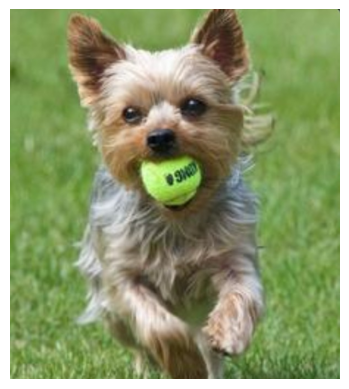

In [1]:
import os
import json
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import tokenizer_from_json 
import matplotlib.pyplot as plt

WORKING_DIR = r"C:\Users\mazen\OneDrive\Desktop\university\Deep Learning and Classification Techniques\project"
model_path = os.path.join(WORKING_DIR, 'best_model.h5')
tokenizer_path = os.path.join(WORKING_DIR, 'tokenizer.json') 

print("Loading tokenizer from JSON...")
with open(tokenizer_path, 'r') as f:
    data = f.read()
    tokenizer = tokenizer_from_json(data)

vocab_size = len(tokenizer.word_index) + 1
max_length = 35
print(f"✅ Tokenizer Loaded! Vocab Size: {vocab_size}")

print("Building model structure...")

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256)(inputs2) 
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

print("Loading weights...")
try:
    model.load_weights(model_path)
    print("✅ Weights loaded successfully.")
except Exception as e:
    print("❌ Error loading weights:", e)

vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption(image_path):
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
    x = preprocess_input(x)
    
    feature = vgg_model.predict(x, verbose=0)
    
    in_text = 'startseq'
    last_word = "" # Keep track of the previous word
    
    for i in range(35):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=35)
        
        yhat = model.predict([feature, sequence], verbose=0)
        
        # Get the top 3 guesses, not just the top 1
        top_indices = np.argsort(yhat[0])[-3:][::-1]
        
        word = None
        for index in top_indices:
            candidate = idx_to_word(index, tokenizer)
            # If the candidate is different from the last word, pick it!
            if candidate != last_word:
                word = candidate
                break
        
        # If all top 3 were the same (rare), just pick the first one
        if word is None:
            word = idx_to_word(top_indices[0], tokenizer)
            
        if word is None: break
        
        in_text += ' ' + word
        last_word = word # Update tracker
        
        if word == 'endseq': break
        
    return in_text.replace('startseq', '').replace('endseq', '')

test_image_path = r"C:\Users\mazen\OneDrive\Desktop\dog.jpg"

print(f"\n📸 Analyzing: {test_image_path}")
try:
    caption = generate_caption(test_image_path)
    print("\n------------------------------------------------")
    print("RESULT:", caption)
    print("------------------------------------------------")
    
    img = load_img(test_image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except Exception as e:
    print("Error:", e)

Loading tokenizer from JSON...
✅ Tokenizer Loaded! Vocab Size: 8766
Building model structure...
Loading weights...
✅ Weights loaded successfully.

📸 Analyzing: C:\Users\mazen\OneDrive\Desktop\test4.jpg

------------------------------------------------
RESULT:  man wearing blue shirt riding bike down the trail 
------------------------------------------------


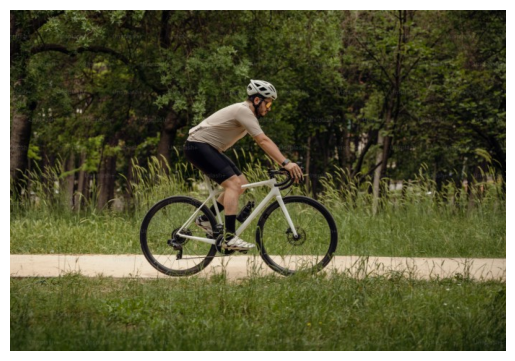

In [9]:
import os
import json
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import tokenizer_from_json # <--- NEW TOOL
import matplotlib.pyplot as plt

WORKING_DIR = r"C:\Users\mazen\OneDrive\Desktop\university\Deep Learning and Classification Techniques\project"
model_path = os.path.join(WORKING_DIR, 'best_model.h5')
tokenizer_path = os.path.join(WORKING_DIR, 'tokenizer.json') 

print("Loading tokenizer from JSON...")
with open(tokenizer_path, 'r') as f:
    data = f.read()
    tokenizer = tokenizer_from_json(data)

vocab_size = len(tokenizer.word_index) + 1
max_length = 35
print(f"✅ Tokenizer Loaded! Vocab Size: {vocab_size}")

print("Building model structure...")

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256)(inputs2) 
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

print("Loading weights...")
try:
    model.load_weights(model_path)
    print("✅ Weights loaded successfully.")
except Exception as e:
    print("❌ Error loading weights:", e)

vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption(image_path):
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
    x = preprocess_input(x)
    
    feature = vgg_model.predict(x, verbose=0)
    
    in_text = 'startseq'
    last_word = "" # Keep track of the previous word
    
    for i in range(35):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=35)
        
        yhat = model.predict([feature, sequence], verbose=0)
        
        # Get the top 3 guesses, not just the top 1
        top_indices = np.argsort(yhat[0])[-3:][::-1]
        
        word = None
        for index in top_indices:
            candidate = idx_to_word(index, tokenizer)
            # If the candidate is different from the last word, pick it!
            if candidate != last_word:
                word = candidate
                break
        
        # If all top 3 were the same (rare), just pick the first one
        if word is None:
            word = idx_to_word(top_indices[0], tokenizer)
            
        if word is None: break
        
        in_text += ' ' + word
        last_word = word # Update tracker
        
        if word == 'endseq': break
        
    return in_text.replace('startseq', '').replace('endseq', '')

test_image_path = r"C:\Users\mazen\OneDrive\Desktop\test4.jpg"

print(f"\n📸 Analyzing: {test_image_path}")
try:
    caption = generate_caption(test_image_path)
    print("\n------------------------------------------------")
    print("RESULT:", caption)
    print("------------------------------------------------")
    
    img = load_img(test_image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except Exception as e:
    print("Error:", e)

Loading tokenizer from JSON...
✅ Tokenizer Loaded! Vocab Size: 8766
Building model structure...
Loading weights...
✅ Weights loaded successfully.

📸 Analyzing: C:\Users\mazen\OneDrive\Desktop\live_demo.jpg

------------------------------------------------
RESULT:  group of people are walking on the ground with their backs to the camera 
------------------------------------------------


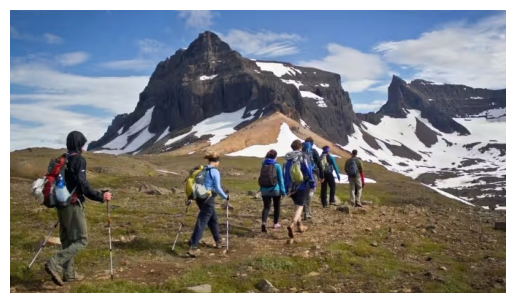

In [8]:
import os
import json
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import tokenizer_from_json # <--- NEW TOOL
import matplotlib.pyplot as plt

WORKING_DIR = r"C:\Users\mazen\OneDrive\Desktop\university\Deep Learning and Classification Techniques\project"
model_path = os.path.join(WORKING_DIR, 'best_model.h5')
tokenizer_path = os.path.join(WORKING_DIR, 'tokenizer.json') 

print("Loading tokenizer from JSON...")
with open(tokenizer_path, 'r') as f:
    data = f.read()
    tokenizer = tokenizer_from_json(data)

vocab_size = len(tokenizer.word_index) + 1
max_length = 35
print(f"✅ Tokenizer Loaded! Vocab Size: {vocab_size}")

print("Building model structure...")

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256)(inputs2) 
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

print("Loading weights...")
try:
    model.load_weights(model_path)
    print("✅ Weights loaded successfully.")
except Exception as e:
    print("❌ Error loading weights:", e)

vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_caption(image_path):
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = x.reshape((1, x.shape[0], x.shape[1], x.shape[2]))
    x = preprocess_input(x)
    
    feature = vgg_model.predict(x, verbose=0)
    
    in_text = 'startseq'
    last_word = "" # Keep track of the previous word
    
    for i in range(35):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=35)
        
        yhat = model.predict([feature, sequence], verbose=0)
        
        # Get the top 3 guesses, not just the top 1
        top_indices = np.argsort(yhat[0])[-3:][::-1]
        
        word = None
        for index in top_indices:
            candidate = idx_to_word(index, tokenizer)
            # If the candidate is different from the last word, pick it!
            if candidate != last_word:
                word = candidate
                break
        
        # If all top 3 were the same (rare), just pick the first one
        if word is None:
            word = idx_to_word(top_indices[0], tokenizer)
            
        if word is None: break
        
        in_text += ' ' + word
        last_word = word # Update tracker
        
        if word == 'endseq': break
        
    return in_text.replace('startseq', '').replace('endseq', '')

test_image_path = r"C:\Users\mazen\OneDrive\Desktop\live_demo.jpg"

print(f"\n📸 Analyzing: {test_image_path}")
try:
    caption = generate_caption(test_image_path)
    print("\n------------------------------------------------")
    print("RESULT:", caption)
    print("------------------------------------------------")
    
    img = load_img(test_image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
except Exception as e:
    print("Error:", e)